# Assignment 2B  - Simulated Annealing

In this assignment, you will run simulations, comparing Hill Climbing and Simulated Annealing.

**_TODO_**

Enter your information below.

**Name:** HaoLiu <br>
**CWID:** A20473685

In [1]:
import time

import numpy as np

import pandas as pd

from matplotlib import pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

from sa_utils import Node
from sa_utils import hill_climbing, simulated_annealing

In [2]:
from tsp_utils import City, TSPNode, read_cities, subsample_cities, create_initial_node
from tsp_utils import plot_cities, plot_path, compare_sols

# Read Data

In [3]:
all_cities = read_cities('berlin52.tsp')
TSPNode._cities = all_cities

# Simulations

You will run simulations for multiple subsets and multiple initializations, like you have done in Assignment 2a. One major difference here is that, in addition to hill climbing (HC), you will also run simulations using simulated annealing (SA).

**_Important_:** You need to pick the temperature schedule and the respective parameters to achieve the best results you can get. The temperature schedule and its parameters depend on the domain, as well as the range of the optimization value (in this case, the -1*cost of the travel plan).

The best parameters might also depend on the size of the problem. For example, the best parameters might be different for 10 cities versus 20 cities.

In [4]:
# Temperature Schedules for SA

# Here, you are given one temperature schedule. 
# You are free to add other schedules, or experiment with only this.

## Exponential multiplicative schedule

def exp_schedule(T_0, l):
    """Returns a function whose input is iter."""
    return lambda iter: T_0 * np.exp(-l * iter)

Example call to simulated annealing:

`_, sa_sol_n = simulated_annealing(initial_n, temp_schedule=exp_schedule(T_0=20, l=0.2), max_iter=100)`

Notes:

1. `simulated_annealing` returns the final state and the best state. Given large enough temperature and enough iterations, these should be the same states, but they might not be. We will work with the best state, which is saved in `sa_sol_n` in this call.

2. These parameter settings are just examples and not the best settings :)

## Simulations 1 - Subsample of 10

1. Create multiple subsamples of cities, of size 10 each.
2. Create multiple initializations for each.
3. Run HC for each.
4. Run SA for each. Try different temperature schedules and parameters. Do NOT share everthing you tried; show us only the setting that achieved the best performance (on average).
5. Present the initial, the HC, and SA results as a table. Your table should include a final row that includes the average values for Initial, HC, and SA.

Use 

* subsample_size = 10
* subsample_seeds of `[0, 1, 2, 3, 4]`
* initial_seeds = `[11, 12, 13, 14, int(last_three_digits_of_your_CWID)]`

In [5]:
# TODO - Write code and run the simulation

CWID='A20473685' # EDIT THIS; CHANGE IT TO YOUR A#.

subsample_size = 10
subsample_seeds = range(0, 5)
initial_seeds = [11, 12, 13, 14, 15, int(CWID[6:])]

#Write code
#function to run the simulation
import pandas as pd
import multiprocessing as mp
import sys
sys.setrecursionlimit(1000000)

def run_simulations(subsample_size, subsample_seeds, initial_seeds,T, l, max_iter,hc_run=True,sa_run=True):

    """
    Run the simulations for the given parameters.
    """
    initial_states = {}
    hc_states = {}
    sa_states = {}
    for subsample_seed in subsample_seeds:
        #ssubsample the cities
        cities = subsample_cities(all_cities, number_of_cities=subsample_size, random_seed=subsample_seed)
        initial_states[subsample_seed] = {}
        hc_states[subsample_seed] = {}
        sa_states[subsample_seed] = {}
        for initial_seed in initial_seeds:
            initial_node = create_initial_node(cities, random_seed=initial_seed)
            initial_states[subsample_seed][initial_seed] = initial_node
            if hc_run:
                hc_states[subsample_seed][initial_seed] = hill_climbing(initial_node)
            if sa_run:
                sa_states[subsample_seed][initial_seed] = simulated_annealing(initial_node, temp_schedule=exp_schedule(T_0=T, l=l), max_iter=max_iter)[1]
    return initial_states, hc_states, sa_states
#function to find best parameters for SA

def find_best_parameters(subsample_size, subsample_seeds, initial_seeds):
    """
    Find the best parameters for SA.
    """
    best_T_0 = 0
    best_l = 0
    best_max_iter = 0
    best_avg = 0
    import  time
    a=time.time()
    df_x = pd.DataFrame(columns=['T_0', 'l', 'max_iter', 'avg'])
    #切换成多进程的方式执行
    pool = mp.Pool(mp.cpu_count())
    for T_0 in range(1100, 1102):
        for l in range(10, 11):
            l=l/5000
            for max_iter in range(1700,1701):
                df_x.loc[len(df_x)] = [T_0, l, max_iter, pool.apply_async(run_simulations, args=(subsample_size, subsample_seeds, initial_seeds,T_0, l, max_iter,False,True))]

    #替换df 里面的avg为pool.apply_async的返回值
    for i in range(len(df_x)):
        print(i,len(df_x))
        initial_states, hc_states, sa_states=df_x.iloc[i,3].get()
        df_x.iloc[i,3]=np.mean([-sa_states[j][i].value() for j in subsample_seeds for i in initial_seeds])
    #计算每个参数组合的平均值

    #draw the plot
    import matplotlib.pyplot as plt
    plt.plot(df_x['avg'])
    plt.show()

    # print(df_x)
    # print(time.time()-a)
    df_x['avg']=df_x['avg'].astype(float)
    #取最小值的行
    df_x=df_x.sort_values(by='avg',ascending=True)
    #获取第一行
    #print(df_x)
    df_x=df_x.iloc[0:1,:]
    #print(df_x)

    return df_x['T_0'].values[0],df_x['l'].values[0],df_x['max_iter'].values[0],df_x['avg'].values[0]


### Results

In [6]:
# TODO: Present a table of the results.
# Note that the entries are costs (-1*value).
# Note that the last row are the mean values.
# Write code

#res=find_best_parameters(subsample_size, subsample_seeds, initial_seeds)
#T,l,max_iter,avg=res
T,l,max_iter=1049,0.002,1700
initial_states, hc_states,sa_states = run_simulations(subsample_size, subsample_seeds, initial_seeds,T,l,max_iter)
def get_df(initial_states, hc_states, sa_states, subsample_seeds, initial_seeds):
    """
    Show the table of results.
    """
    df = pd.DataFrame(columns=['Subsample Seed', 'Initial Seed', 'Initial Value', 'HC Value'])
    df['Subsample Seed'] = [ j for j in subsample_seeds for i in initial_seeds]
    df['Initial Seed'] = [ i for j in subsample_seeds for i in initial_seeds]
    df['Initial Value'] = [-initial_states[j][i].value() for j in subsample_seeds for i in initial_seeds]
    df['HC Value'] = [-hc_states[j][i].value() for j in subsample_seeds for i in initial_seeds]
    df['SA best Value'] = [-sa_states[j][i].value() for j in subsample_seeds for i in initial_seeds]
    #add avg row
    df.loc['mean'] = df.mean()
    df.loc['mean', 'Subsample Seed'] = '-'
    df.loc['mean', 'Initial Seed'] = '-'
    return df
display(get_df(initial_states, hc_states, sa_states, subsample_seeds, initial_seeds))

,Subsample Seed,Initial Seed,Initial Value,HC Value,SA best Value
0,0.0,11.0,6910.854964,4845.283431,3661.643228
1,0.0,12.0,4805.420205,4578.810278,3835.567764
2,0.0,13.0,6281.931261,6230.336304,3646.276239
3,0.0,14.0,6547.397559,4943.598730,3848.508855
4,0.0,15.0,6567.276372,3994.034490,3646.276239
5,0.0,685.0,4089.327327,3939.512675,3726.512489
6,1.0,11.0,3897.908590,2195.289900,1946.226847
7,1.0,12.0,3851.562313,3140.493238,1910.703722
8,1.0,13.0,3343.303102,2746.034130,1924.937867
9,1.0,14.0,2431.764939,2159.997566,1910.703722


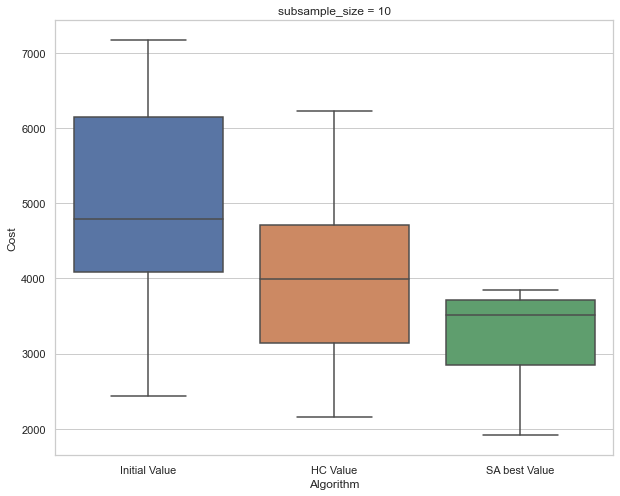

In [7]:
# TODO: Plot a boxplot of the cost values for Initial, HC, and SA.

# Write code
def plot_boxplot(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(style="whitegrid")
    df = df.drop(['Subsample Seed', 'Initial Seed'], axis=1)
    df = df.melt(var_name='Algorithm', value_name='Cost')
    ax = sns.boxplot(x="Algorithm", y="Cost", data=df)
    ax.set_title('subsample_size = '+str(subsample_size))
    plt.show()
plot_boxplot(get_df(initial_states, hc_states, sa_states, subsample_seeds, initial_seeds))

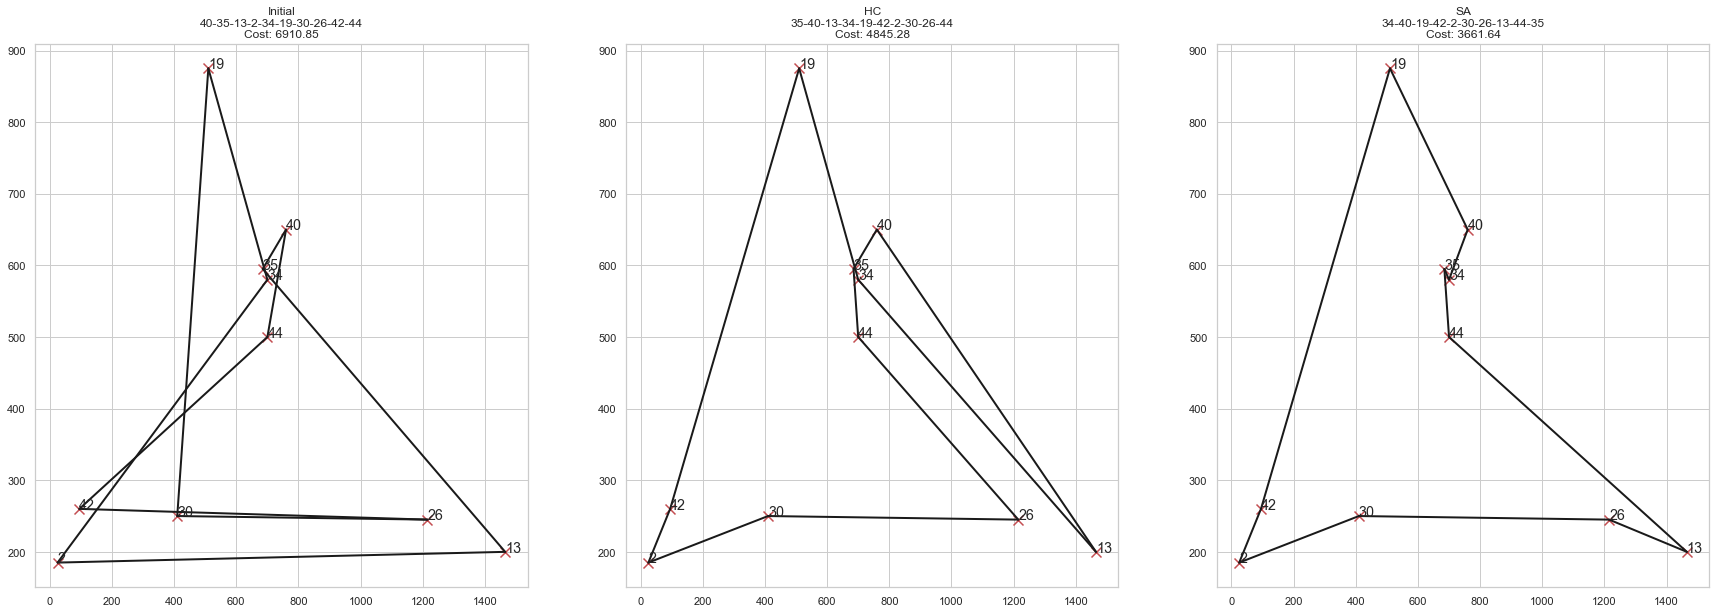

In [8]:
# TODO: Pick subsample seed and initial seed, and visualize Initialization, HC, and SA.
# Use the compare_sols function.
compare_sols((("Initial", initial_states[subsample_seeds[0]][initial_seeds[0]]),("HC",hc_states[subsample_seeds[0]][initial_seeds[0]]),("SA", sa_states[subsample_seeds[0]][initial_seeds[0]])), all_cities)

### SA Parameter Settings for Subsample 10

The best  parameter settings I found for subsample 20 are as follows.
T=1049
l=0.002
max_iter=1700

**_TODO_**

temp_schedule=exp_schedule(T_0=1049, l=0.002), max_iter=1700

# Simulations 20, 30, 40, Full Data

Repeat the above simulations, tables, and plots for

* subsample of 20
* subsample of 30
* subsample of 40
* Full data (no subsampling for full data, only random initialization).

You need to choose the best parameter settings and report them.

## Simulations - Subsample 20

,Subsample Seed,Initial Seed,Initial Value,HC Value,SA best Value
0,0.0,11.0,14528.512545,9409.188607,7911.075236
1,0.0,12.0,12492.176845,9553.188395,8498.185461
2,0.0,13.0,12938.237671,11515.194157,7564.438928
3,0.0,14.0,12529.839281,10628.089376,6980.742624
4,0.0,15.0,11961.551958,10324.493947,7804.553411
5,0.0,685.0,12764.576346,7868.568848,6832.545693
6,1.0,11.0,8315.996528,5971.753474,5883.465393
7,1.0,12.0,8106.832988,5710.267338,4463.806504
8,1.0,13.0,7919.323807,6222.817913,4514.532833
9,1.0,14.0,7841.527843,5757.361661,4899.048645


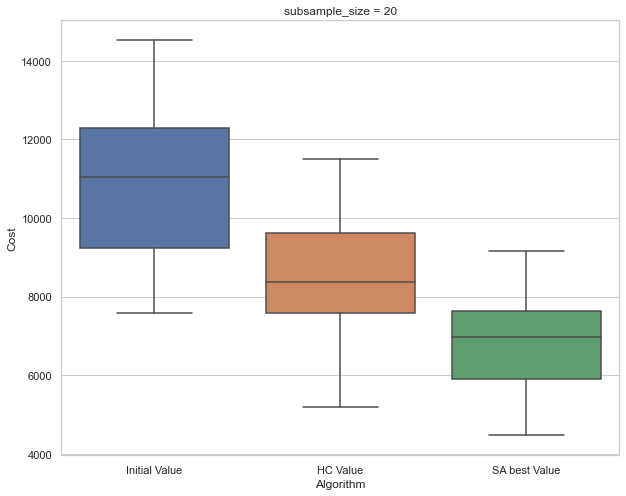

In [9]:
# Run simulations using different temperature settings and pick the best setting.
subsample_size = 20
# res=find_best_parameters(subsample_size, subsample_seeds, initial_seeds)
# print(res)
T,l,max_iter=819,0.002,1699
initial_states, hc_states,sa_states = run_simulations(subsample_size, subsample_seeds, initial_seeds,T,l,max_iter)
df=get_df(initial_states, hc_states, sa_states, subsample_seeds, initial_seeds)
display(df)
plot_boxplot(df)

### Results

Table, boxplot, and path visualizations.

### SA Parameter Settings for Subsample 20

The best  parameter settings I found for subsample 20 are as follows.
T=819
l=0.002
max_iter=1699
**_TODO_**

temp_schedule=exp_schedule(T_0=819, l=0.002), max_iter=1699

## Simulations - Subsample 30

,Subsample Seed,Initial Seed,Initial Value,HC Value,SA best Value
0,0.0,11.0,18452.333046,14751.060989,11810.144179
1,0.0,12.0,16392.240025,13710.665979,10299.836713
2,0.0,13.0,19073.027869,13446.357383,11021.410272
3,0.0,14.0,18543.235765,14528.437203,12490.746856
4,0.0,15.0,18072.423051,12982.142435,12057.756919
5,0.0,685.0,19757.068889,12084.093737,12675.672209
6,1.0,11.0,14617.254235,11752.905682,8610.993907
7,1.0,12.0,12924.087636,11395.282251,9903.647900
8,1.0,13.0,13329.522781,11252.846115,10460.166082
9,1.0,14.0,13921.360320,10533.700060,8301.982590


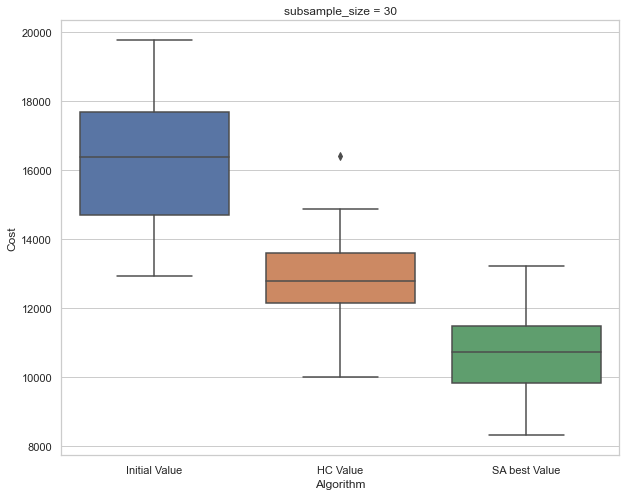

In [10]:
subsample_size = 30
#res=find_best_parameters(subsample_size, subsample_seeds, initial_seeds)
#print(res)
T,l,max_iter=1262,0.002,1700
initial_states, hc_states,sa_states = run_simulations(subsample_size, subsample_seeds, initial_seeds,T,l,max_iter)
df=get_df(initial_states, hc_states, sa_states, subsample_seeds, initial_seeds)
display(df)
plot_boxplot(df)

### SA Parameter Settings for Subsample 30

#The best  parameter settings I found for subsample 30 are as follows.
T=1262
l=0.002
max_iter=1700
**_TODO_**

temp_schedule=exp_schedule(T_0=1262, l=0.002), max_iter=1700

## Simulations - Subsample 40

,Subsample Seed,Initial Seed,Initial Value,HC Value,SA best Value
0,0.0,11.0,22422.827965,18173.154615,15064.884294
1,0.0,12.0,24004.194769,18844.451113,15204.604182
2,0.0,13.0,24314.444478,19406.699556,13804.493662
3,0.0,14.0,23950.875799,18255.824281,15886.042057
4,0.0,15.0,25058.430067,18536.135701,14860.732077
5,0.0,685.0,22871.791725,19439.177595,16115.531789
6,1.0,11.0,21039.012888,15656.884408,13628.667174
7,1.0,12.0,22582.888615,17234.947213,12909.224832
8,1.0,13.0,20314.188732,15903.115885,12496.907131
9,1.0,14.0,21356.947180,16087.632942,15833.867543


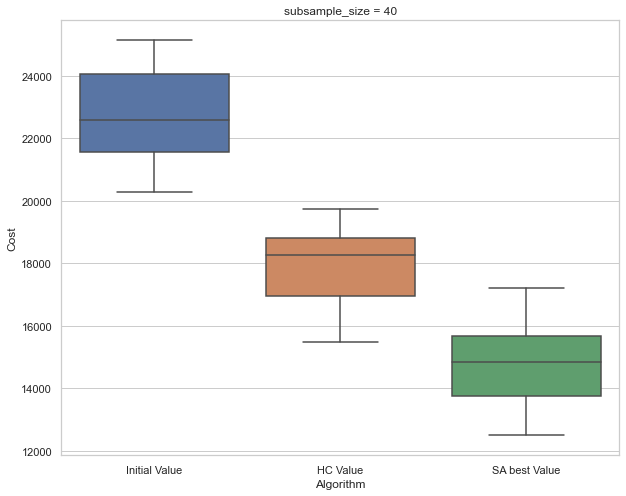

In [11]:
subsample_size = 40
#res=find_best_parameters(subsample_size, subsample_seeds, initial_seeds)
#print(res)
T,l,max_iter=1048,0.002,1700
initial_states, hc_states,sa_states = run_simulations(subsample_size, subsample_seeds, initial_seeds,T,l,max_iter)
df=get_df(initial_states, hc_states, sa_states, subsample_seeds, initial_seeds)
display(df)
plot_boxplot(df)

### SA Parameter Settings for Subsample 40

#The best  parameter settings I found for subsample 40 are as follows.
T=1048
l=0.002
max_iter=1700
**_TODO_**

temp_schedule=exp_schedule(T_0=1048, l=0.002), max_iter=1700

## Simulations - Full Data

Note: for the full data, you do not perform subsampling. Run only the random initializations.

,Subsample Seed,Initial Seed,Initial Value,HC Value,SA best Value
0,0.0,11.0,31341.440592,24386.679891,20380.026737
1,0.0,12.0,28501.327303,22336.651571,20344.455297
2,0.0,13.0,29191.886193,22960.907423,20891.076907
3,0.0,14.0,33497.821978,24220.819770,21033.928561
4,0.0,15.0,28864.122676,23114.078512,19770.380030
5,0.0,685.0,29767.168904,23499.217536,18129.943389
6,1.0,11.0,27733.692461,22213.206925,18700.348163
7,1.0,12.0,33503.439105,26638.790908,21312.308563
8,1.0,13.0,33253.988918,25542.650339,20780.400837
9,1.0,14.0,28666.006138,24951.430933,19352.854760


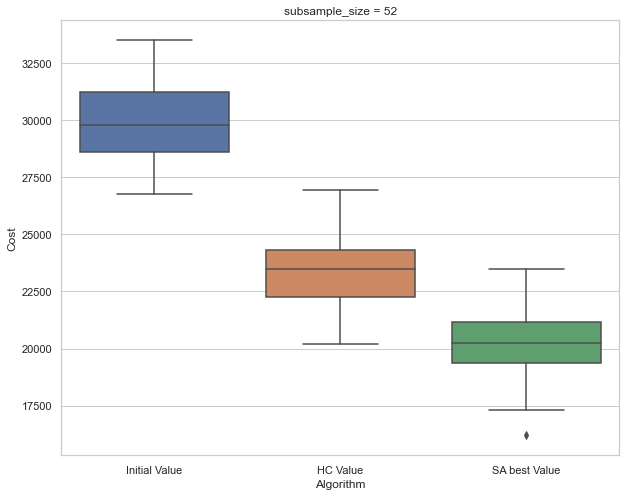

In [12]:

subsample_size = len(all_cities)
#res=find_best_parameters(subsample_size, subsample_seeds, initial_seeds)
T,l,max_iter=1100,0.002,1700
initial_states, hc_states,sa_states = run_simulations(subsample_size, subsample_seeds, initial_seeds,T,l,max_iter)
df=get_df(initial_states, hc_states, sa_states, subsample_seeds, initial_seeds)
display(df)
plot_boxplot(df)

### SA Parameter Settings for full data

#The best  parameter settings I found for full  data are as follows.
T=1100
l=0.002
max_iter=1700
**_TODO_**

temp_schedule=exp_schedule(T_0=1100, l=0.002), max_iter=1700

# Report

Discuss your findings and your experience with these simulations. This part of the question is worth 5 points.

My main feelings throughout the process are:

1、Finding the best solution may be difficult or low cost-effective.


2、In a limited time, I first assume that each parameter is independent of each other and each has a trend:


   For example, suppose that max_iter will gradually reduce the average cost as the value increases until it enters a stable period. I hope to find this stable period first.
   
   
3、Try to observe whether when several parameters are combined, whether there is a situation of breaking through various independent situations.


4、In the proximity of the optimal solution independent of each parameter, combine and then grid search to select the optimal parameter combination.


5、There is a little difference between different subsamples




